In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
main_path = '/kaggle/input/deepfake-database/deepfake_database'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'validation')
test_dir = os.path.join(main_path, 'test')

In [3]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(valid_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['real', 'df']
Valid_dir Subfolders:  ['real', 'df']
Test_dir Subfolders:  ['real', 'df']


In [5]:
images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(main_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [6]:
images_df = pd.DataFrame(images_df)

In [7]:
images_df

,folder,image_path,label
0,validation,/kaggle/input/deepfake-database/deepfake_datab...,real
1,validation,/kaggle/input/deepfake-database/deepfake_datab...,real
2,validation,/kaggle/input/deepfake-database/deepfake_datab...,real
3,validation,/kaggle/input/deepfake-database/deepfake_datab...,real
4,validation,/kaggle/input/deepfake-database/deepfake_datab...,real
...,...,...,...
19451,train,/kaggle/input/deepfake-database/deepfake_datab...,df
19452,train,/kaggle/input/deepfake-database/deepfake_datab...,df
19453,train,/kaggle/input/deepfake-database/deepfake_datab...,df
19454,train,/kaggle/input/deepfake-database/deepfake_datab...,df


In [8]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "df"].groupby('folder')

In [9]:
real_grouped_df.size()

folder
test           165
train         7084
validation    4259
dtype: int64

In [10]:
fake_grouped_df.size()

folder
test           165
train         4938
validation    2845
dtype: int64

In [11]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [12]:
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 12023 images belonging to 2 classes.
Found 7104 images belonging to 2 classes.
Found 330 images belonging to 2 classes.


In [13]:
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if label[i] == 0:
            plt.title("Fake")
        else:
            plt.title("Real")

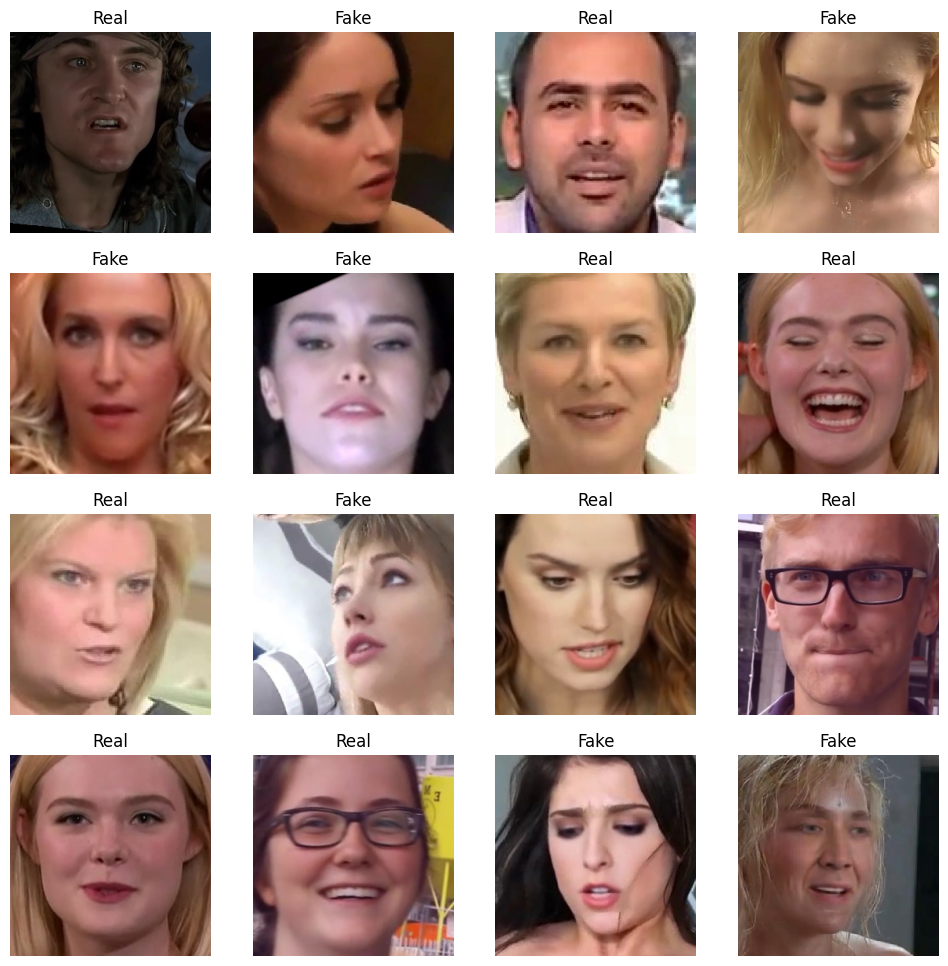

In [14]:
img,lbl = next(train_ds)
plot_images(img,lbl)

In [15]:
for img, label in train_ds:
    print("Values: ", img[0])
    print("Label: ", label[0])
    break

Values:  [[[0.08235294 0.07450981 0.08627451]
  [0.08235294 0.07450981 0.08627451]
  [0.08235294 0.07450981 0.08627451]
  ...
  [0.882353   0.49803925 0.46274513]
  [0.86274517 0.45882356 0.42352945]
  [0.86274517 0.45882356 0.42352945]]

 [[0.08235294 0.07450981 0.08627451]
  [0.08235294 0.07450981 0.08627451]
  [0.08235294 0.07450981 0.08627451]
  ...
  [0.882353   0.49803925 0.46274513]
  [0.86274517 0.45882356 0.42352945]
  [0.86274517 0.45882356 0.42352945]]

 [[0.07843138 0.07058824 0.08235294]
  [0.07843138 0.07058824 0.08235294]
  [0.07843138 0.07058824 0.08235294]
  ...
  [0.882353   0.49803925 0.46274513]
  [0.86274517 0.45882356 0.42352945]
  [0.86274517 0.45882356 0.42352945]]

 ...

 [[0.20000002 0.15294118 0.19215688]
  [0.20000002 0.15294118 0.19215688]
  [0.19607845 0.14901961 0.18823531]
  ...
  [0.6784314  0.57254905 0.5921569 ]
  [0.78823537 0.6745098  0.69411767]
  [0.78823537 0.6745098  0.69411767]]

 [[0.20000002 0.15294118 0.19215688]
  [0.20000002 0.15294118 0.1

In [16]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(64, 256, 256, 3)
(64,)


In [17]:
train_ds.class_indices

{'df': 0, 'real': 1}

In [19]:
input_shape = (256, 256, 3) #define the input shape of our data

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2,ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler


In [19]:
# Create and compile the discriminator model
base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [20]:
from tensorflow.keras import layers, models, regularizers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),  # Additional dense layer
    layers.Dropout(0.4),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

In [21]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [22]:
checkpoint_filepath = "model_cp.h5"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=5,
                                                     restore_best_weights=True,
                                                    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)

In [23]:

model.fit(
    train_ds,
    epochs=5,
    validation_data=valid_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr]
)

Epoch 1/5
188/188 [==============================] - 202s 1s/step - loss: 0.3462 - accuracy: 0.8478 - val_loss: 0.3919 - val_accuracy: 0.8211 - lr: 0.0010
Epoch 2/5
188/188 [==============================] - 67s 356ms/step - loss: 0.1966 - accuracy: 0.9192 - val_loss: 0.3581 - val_accuracy: 0.8490 - lr: 0.0010
Epoch 3/5
188/188 [==============================] - 65s 345ms/step - loss: 0.1702 - accuracy: 0.9342 - val_loss: 0.5383 - val_accuracy: 0.7803 - lr: 0.0010
Epoch 4/5
188/188 [==============================] - 66s 350ms/step - loss: 0.1500 - accuracy: 0.9427 - val_loss: 0.3865 - val_accuracy: 0.8425 - lr: 0.0010
Epoch 5/5
188/188 [==============================] - 65s 345ms/step - loss: 0.1444 - accuracy: 0.9418 - val_loss: 0.4094 - val_accuracy: 0.8316 - lr: 0.0010


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Accuracy: {test_accuracy}')

# Make predictions on the test set
predictions = (model.predict(test_ds) > 0.5).astype(int)

# Calculate additional metrics
true_labels = test_ds.classes
f1 = f1_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Confusion Matrix:\n{conf_matrix}')

6/6 [==============================] - 3s 594ms/step - loss: 0.2772 - accuracy: 0.9091
Test Accuracy: 0.9090909361839294
6/6 [==============================] - 2s 167ms/step
F1 Score: 0.9157303370786517
Precision: 0.8534031413612565
Recall: 0.9878787878787879
Confusion Matrix:
[[137  28]
 [  2 163]]


1/1 [==============================] - 0s 22ms/step


Text(0.5, 1.0, 'This image is 3.60% Fake and 96.40% Real.')

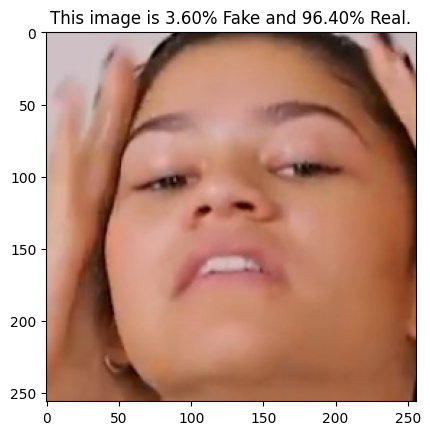

In [29]:
#real example
test_image = tf.keras.preprocessing.image.load_img('/kaggle/input/deepfake-database/deepfake_database/test/real/real07090.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")


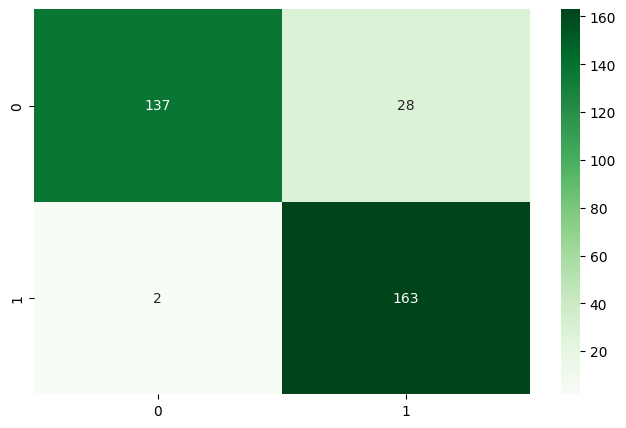

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predictions), annot = True,fmt="d",cmap = "Greens")
plt.show()